In [1]:
import secrets
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
from random import uniform
import time

class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used
        self.tx_hash = secrets.token_bytes(8)
        
    def __lt__(self, other):
        return self.gas_premium < other.gas_premium

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 16000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
    "PER_TX_GASLIMIT": 8000000
}

In [3]:
class Block():
    def __init__(self, txs):
        self.txs = txs

In [4]:
def is_valid(tx, basefee):
    return tx.fee_cap >= basefee

In [5]:
def update_demand_scenario(params, step, sL, s, _input):
    timestep = s["timestep"]
    demand = s["demand"]
    tx_scenario = s["scenario"]
    
    start = time.time()
    for i in range(tx_scenario[timestep]):
        gas_premium = uniform(1, 11) * (10 ** 9)
        fee_cap = gas_premium + uniform(1, 11) * (10 ** 9)
        tx = Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )
        demand[tx.tx_hash] = tx
    print("step =", timestep, ", mempool size =", len(demand), ", update demand", time.time() - start)
        
    return ("demand", demand)

In [6]:
def include_valid_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    timestep = s["timestep"]
    
    start = time.time()
    sorted_valid_demand = sorted([tx for tx_hash, tx in demand.items() if is_valid(tx, basefee)], key = lambda tx: -tx.gas_premium)
    included_transactions = sorted_valid_demand[0:570]
    print("time to sort", time.time() - start)
    
    return ({ "block": Block(txs = included_transactions) })

In [7]:
def update_basefee(params, step, sL, s, _input):
    block = _input["block"]
    basefee = s["basefee"]
    
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    return ("basefee", new_basefee)

In [8]:
def record_latest_block(params, step, sL, s, _input):
    block = _input["block"]
    
    return ("latest_block", block)

In [9]:
def remove_included_txs(params, step, sL, s, _input):
    demand = s["demand"]
    latest_block = _input["block"]
    
    start = time.time()
    for tx in latest_block.txs:
        del(demand[tx.tx_hash])
    print("time to remove from txs =", time.time() - start)
        
    return ("demand", demand)

In [10]:
def end_loop(params, step, sL, s, _input):
    print("loop time", time.time() - s["loop_time"])
    return ("loop_time", time.time())

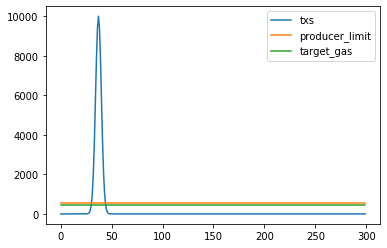

In [11]:
from math import pow, exp

timesteps = 300

def generate_spike_scenario(timesteps):
    spikey_boi = timesteps // 8
    return [int(10000 * exp(-pow(i - spikey_boi, 2)/16.0)) for i in range(timesteps)]

tx_scenario = generate_spike_scenario(timesteps)
pd.DataFrame({ "txs": tx_scenario, "producer_limit": 570, "target_gas": 476 }).plot()

In [12]:
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_scenario
    }
}, {
    "policies": {
        "action": include_valid_txs # step 2
    },
    "variables": {
        "demand": remove_included_txs,
        "basefee": update_basefee,
        "latest_block": record_latest_block,
        "loop_time": end_loop
    }
}]

initial_conditions = {
    "scenario": tx_scenario,
    "basefee": 5 * (10 ** 9),
    "demand": {},
    "latest_block": Block(txs=[]),
    "loop_time": time.time()
}

simulation_parameters = {
    'T': range(timesteps),
    'N': 1,
    'M': {}
}

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=psub,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x123e95080>]
Configurations: [<cadCAD.configuration.Configuration object at 0x123e95080>]
step = 0 , mempool size = 0 , update demand 1.9073486328125e-06
time to sort 3.0994415283203125e-06
time to remove from txs = 9.5367431640625e-07
loop time 0.02404022216796875
step = 1 , mempool size = 0 , update demand 1.1920928955078125e-06
time to sort 3.0994415283203125e-06
time to remove from txs = 9.5367431640625e-07
loop time 0.0016362667083740234
step = 2 , mempool size = 0 , update demand 9.5367431640625e-07
time to sort 3.0994415283203125e-06
time to remove from txs = 9.5367431640625e-07
loop time 0.0016169548034667969
step = 3 , mempool size = 0 ,

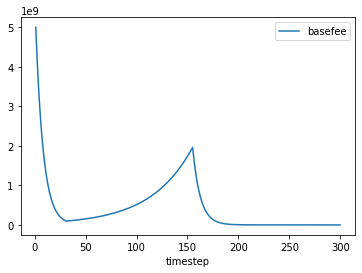

In [13]:
df[df.substep == 1].plot("timestep", "basefee")

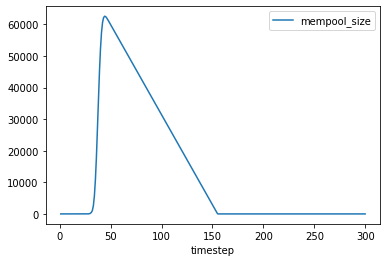

In [14]:
df["mempool_size"] = df.demand.apply(
    lambda demand: len(demand)
)
df[df.substep == 1].plot("timestep", "mempool_size")

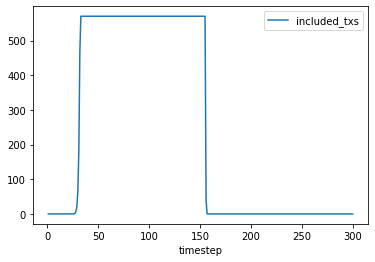

In [15]:
df["included_txs"] = df.latest_block.apply(
    lambda block: len(block.txs)
)
df[df.substep == 1].plot("timestep", "included_txs")